In [1]:
import pandas as pd
import georinex as gr
import misc
from plots import *
import matplotlib.dates as mdates
import datetime
import matplotlib
import copy

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from logparser import LogReader, PosReader

# Prepare the data

In [2]:
# Load log files
measurements_log = ['Raw', 'Fix']
measurements_RINEX = ['C1C']
logs = []

log = LogReader(manufacturer="Google", device="Pixel 7", specifiedTags=measurements_log, mode="logger", 
                filepath="../.data/2023_Dataset_Hervanta/S1_static/raw/log_GooglePixel7_20230217095501.txt")
log.ref = gr.load('../.data/2023_Dataset_Hervanta/S1_static/_reference/base/TAUN00FIN_R_20230480000_01D_30S_MO.rnx',
              tlim=[log.raw.iloc[0].name.isoformat(), log.raw.iloc[-1].name.isoformat()],
              meas=measurements_RINEX)
logs.append(log)

log = LogReader(manufacturer="Google", device="Pixel Watch", specifiedTags=measurements_log, mode="mimir", 
                filepath="../.data/2023_Dataset_Hervanta/S1_static/raw/log_GooglePixelWatch_20230814145154.txt")
log.ref = gr.load('../.data/2023_Dataset_Hervanta/S1_static/_reference/base/TAUN00FIN_R_20232260000_01D_30S_MO.rnx',
              tlim=[log.raw.iloc[0].name.isoformat(), log.raw.iloc[-1].name.isoformat()],
              meas=measurements_RINEX)
logs.append(log)

log = LogReader(manufacturer="OnePlus", device="Nord 2", specifiedTags=measurements_log, mode="logger", 
                filepath="../.data/2023_Dataset_Hervanta/S1_static/raw/log_OnePlusNord2_20230303105504.txt")
log.ref = gr.load('../.data/2023_Dataset_Hervanta/S1_static/_reference/base/TAUN00FIN_R_20230620000_01D_30S_MO.rnx',
              tlim=[log.raw.iloc[0].name.isoformat(), log.raw.iloc[-1].name.isoformat()],
              meas=measurements_RINEX)
logs.append(log)

log = LogReader(manufacturer="Samsung", device="A52", specifiedTags=measurements_log, mode="logger", 
                filepath="../.data/2023_Dataset_Hervanta/S1_static/raw/log_SamsungA52_20230317141230.txt")
log.ref = gr.load('../.data/2023_Dataset_Hervanta/S1_static/_reference/base/TAUN00FIN_R_20230760000_01D_30S_MO.rnx',
              tlim=[log.raw.iloc[0].name.isoformat(), log.raw.iloc[-1].name.isoformat()],
              meas=measurements_RINEX)
logs.append(log)

log = LogReader(manufacturer="Xiaomi", device="11T", specifiedTags=measurements_log, mode="logger", 
                filepath="../.data/2023_Dataset_Hervanta/S1_static/raw/log_Xiaomi11_20230303095606.txt")
log.ref = gr.load('../.data/2023_Dataset_Hervanta/S1_static/_reference/base/TAUN00FIN_R_20230620000_01D_30S_MO.rnx',
              tlim=[log.raw.iloc[0].name.isoformat(), log.raw.iloc[-1].name.isoformat()],
              meas=measurements_RINEX)
logs.append(log)


In [3]:
log.raw.loc[log.raw['prn'].isin(['G30-L1']), ['TimeNanos', 'AccumulatedDeltaRangeMeters', 'PhaseVelocity', 'PhaseError']]


,TimeNanos,AccumulatedDeltaRangeMeters,PhaseVelocity,PhaseError
datetime,,,,
2023-03-03 07:56:12,1.109580e+11,1.157872e+04,NaN,NaN
2023-03-03 07:56:13,1.119580e+11,1.320560e+04,1626.885318,NaN
2023-03-03 07:56:20,1.189580e+11,2.457599e+04,1624.341470,-0.363407
2023-03-03 07:56:28,1.269580e+11,3.756800e+04,1624.000660,-0.042601
2023-03-03 07:56:29,1.279580e+11,3.919295e+04,1624.956413,0.955753
...,...,...,...,...
2023-03-03 08:28:21,2.039966e+12,2.701679e+06,1874.120283,-0.695105
2023-03-03 08:28:23,2.041966e+12,2.705428e+06,1874.254097,0.066907
2023-03-03 08:28:30,2.048966e+12,2.388159e+06,-45324.048717,-6742.614688


In [4]:
# Compute ENU errors
ref_enu = [61.44922404, 23.8562781, 162.711]
for log in logs:
    log.fix[["east", "north", "up"]] = log.fix.apply(
        lambda row: misc.convert2ENU(row['latitude'], row['longitude'], row['altitude'], ref_enu), 
        axis='columns', result_type='expand')
    
    log.fix[["2D_error"]] = log.fix.apply(
        lambda row: misc.getHorizontalError(row['east'], row['north']), 
        axis='columns', result_type='expand')
    
    log.fix[["3D_error"]] = log.fix.apply(
        lambda row: misc.get3DError(row['east'], row['north'], row['up']), 
        axis='columns', result_type='expand')

# Results

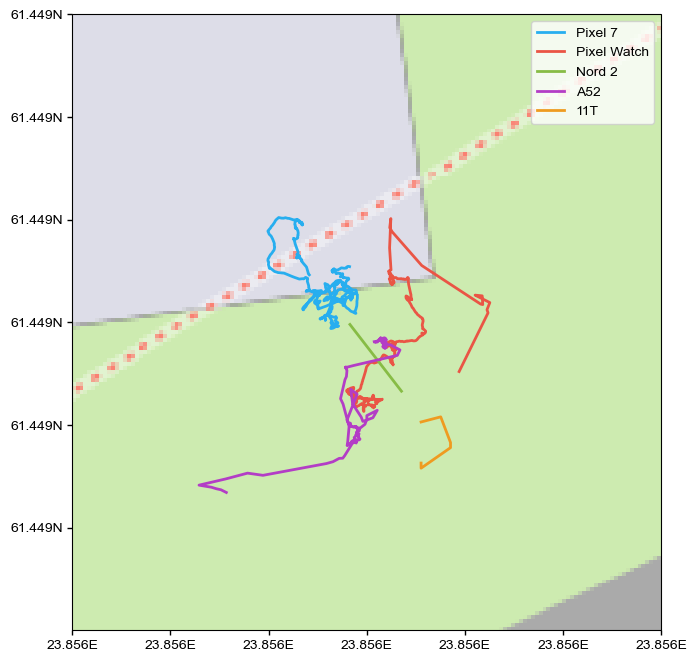

In [5]:
center = ref_enu[:2]
#extent = [center[1] - 0.02, center[1] + 0.005, center[0] - 0.005, center[0] + 0.005]
extent = [center[1] - 0.0002, center[1] + 0.0002, center[0] - 0.0001, center[0] + 0.0001]

locations = {}
for log in logs:
    locations[log.device] = log.fix.loc[log.fix['provider'].isin(['GPS']), ["latitude", "longitude"]]

plotMap(locations=locations, extent=extent, scale=19)

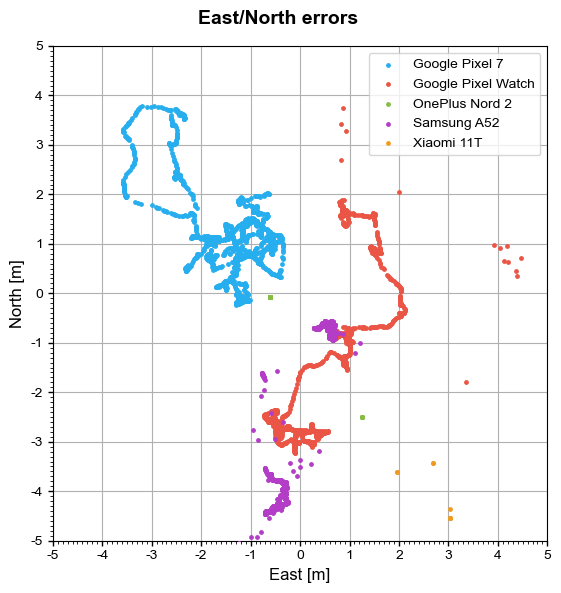

In [6]:
plotEN(logs, lim=5, ticks=[0.1, 1])

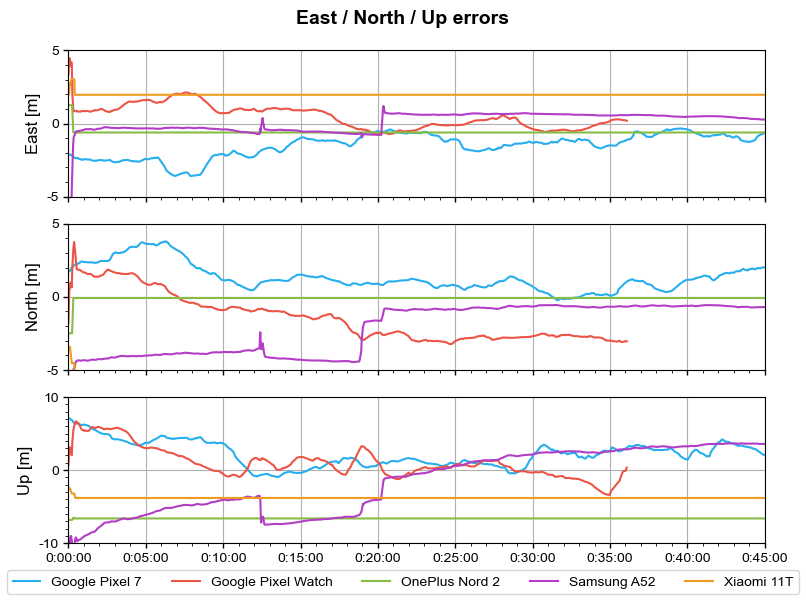

In [7]:
plotENU(logs, lim=[5,5,10], ticks=[1, 5, 1, 5, 1, 10])

### Visibility

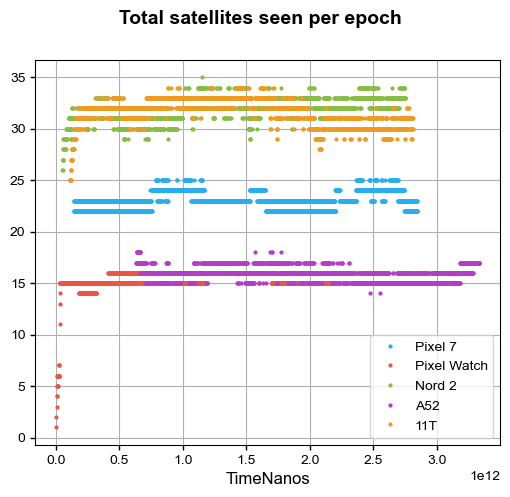

In [8]:
plotTotalSatellitesPerEpochs(logs)

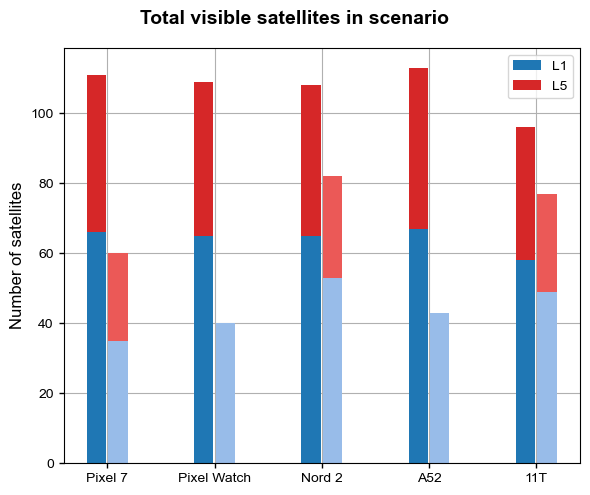

In [9]:
plotTotalSatellitesBar(logs, normalised=False)

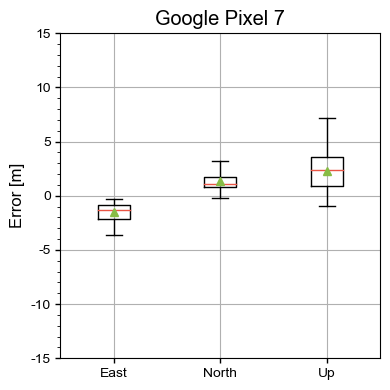

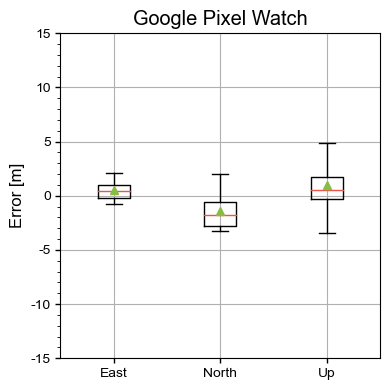

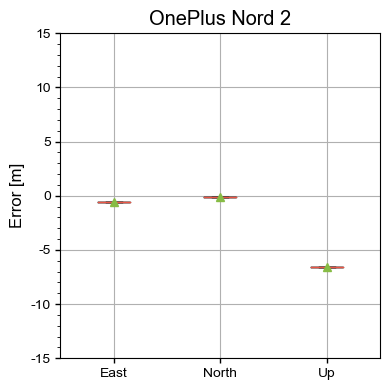

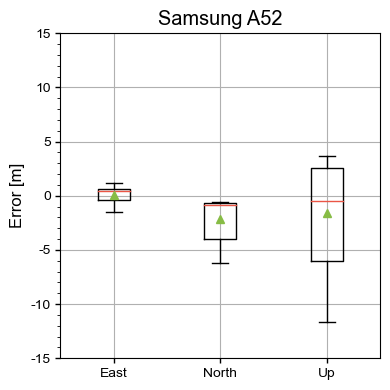

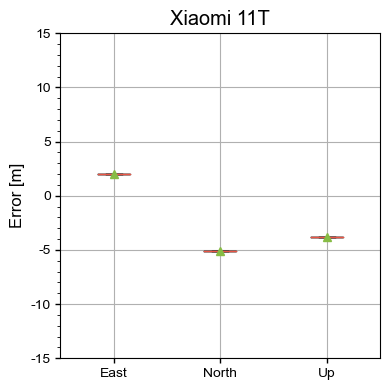

In [10]:
plotStatisticsENU(logs, lim=15, ticks=[1, 5], mode='box')

### Measurements

Pseudoranges

Rows removed 60 (0.100%)
Rows removed 22 (0.069%)
Rows removed 0 (0.000%)
Rows removed 8 (0.019%)
Rows removed 32 (0.039%)


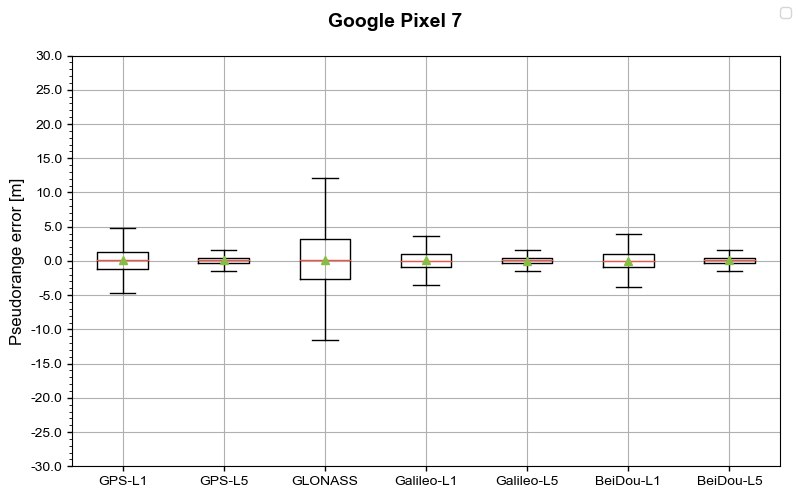

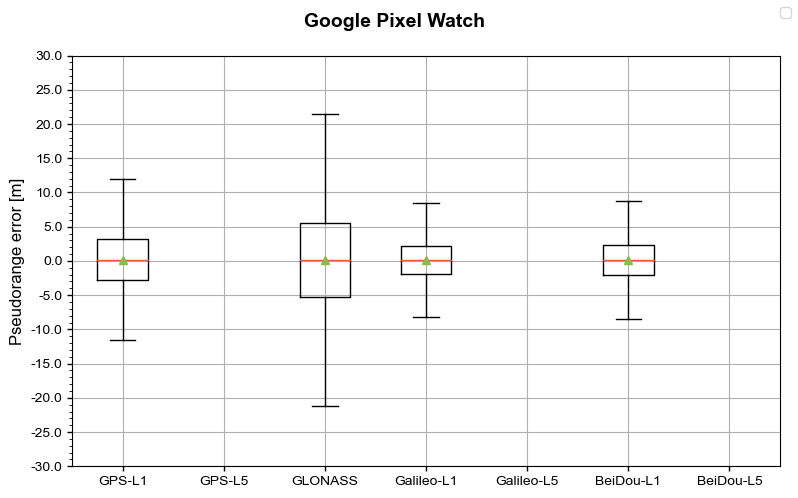

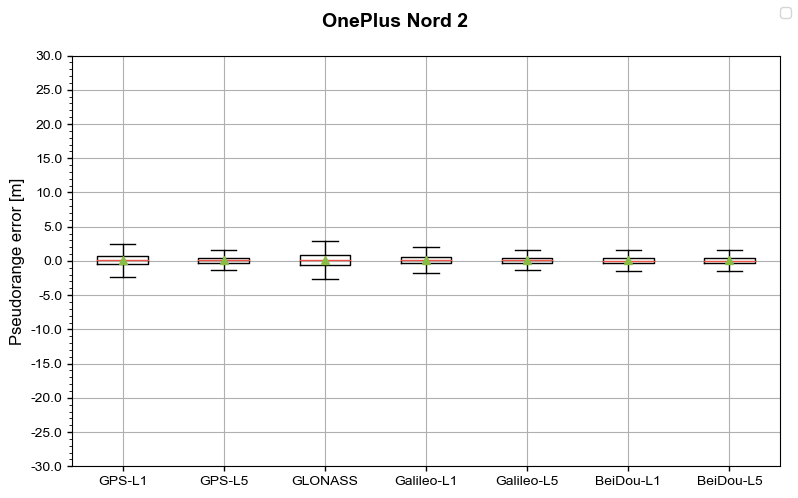

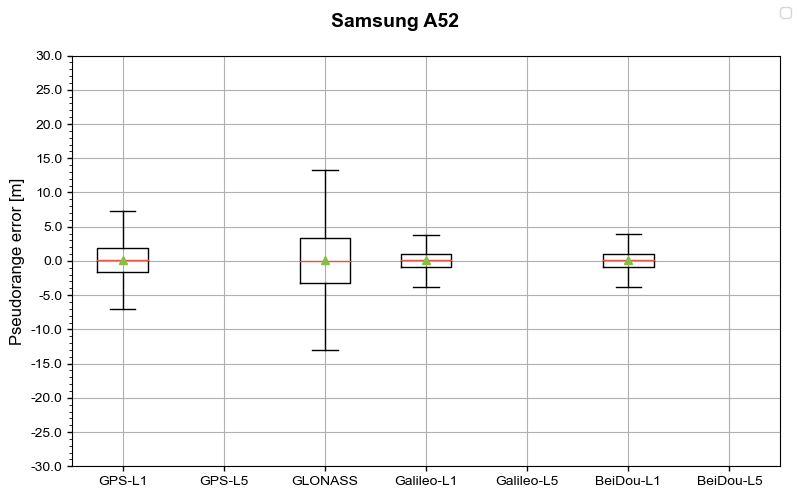

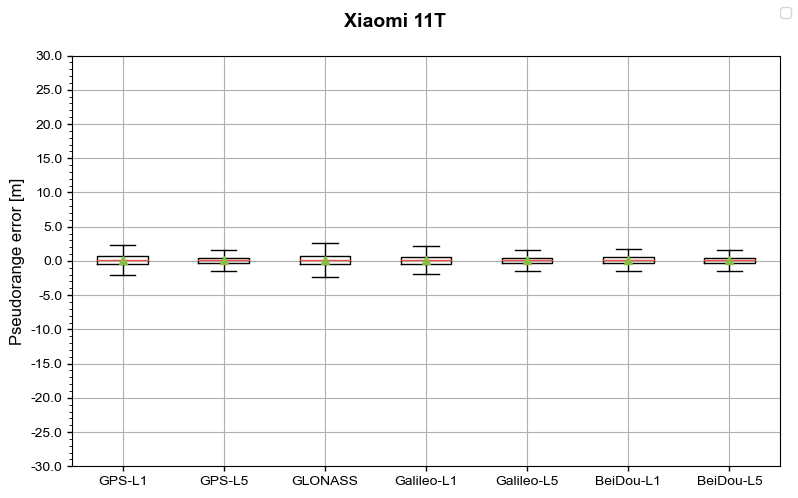

In [11]:
_logs = copy.deepcopy(logs)
for log in _logs:
    log.raw = misc.filterValues(log.raw, 'PseudorangeAcceleration', 300)
    log.raw[list(misc.GnssState_Str.values())] = log.raw.apply(lambda row: misc.getSplitState(row['State'], bits=17, type='tracking'), axis='columns', result_type='expand')
plotStatisticsDataBox(_logs, 
                      'PseudorangeAcceleration', 
                      'Pseudorange error [m]', 
                      ('G', 'R', 'E', 'C'), 
                      ('L1', 'L5'),
                      lim=30,
                      ticks=[1,5])

In [12]:
for log in _logs:
    print(f"--- {log.device} ---")
    count = log.raw[list(misc.GnssState_Str.values())].count()
    df = log.raw[list(misc.GnssState_Str.values())].sum().div(count).mul(100).transpose()
    print(df)

--- Pixel 7 ---
TRACK_UNKNOWN                   0.000000
TRACK_CODE_LOCK                73.147455
TRACK_BIT_SYNC                 79.367217
TRACK_SUBFRAME_SYNC            50.180391
TRACK_TOW_DECODED              34.683359
TRACK_MSEC_AMBIGUOUS            0.000000
TRACK_SYMBOL_SYNC              79.367217
TRACK_GLO_STRING_SYNC           2.651836
TRACK_GLO_TOD_DECODED           2.651836
TRACK_BDS_D2_BIT_SYNC           0.000000
TRACK_BDS_D2_SUBFRAME_SYNC      0.000000
TRACK_GAL_E1BC_CODE_LOCK       15.548573
TRACK_GAL_E1C_2ND_CODE_LOCK    28.031323
TRACK_GAL_E1B_PAGE_SYNC         0.000000
TRACK_SBAS_SYNC                 0.000000
TRACK_TOW_KNOWN                97.348164
TRACK_GLO_TOD_KNOWN             2.651836
TRACK_S_2ND_CODE_LOCK          71.218847
dtype: float64
--- Pixel Watch ---
TRACK_UNKNOWN                   0.000000
TRACK_CODE_LOCK                67.268081
TRACK_BIT_SYNC                 91.711072
TRACK_SUBFRAME_SYNC            44.342651
TRACK_TOW_DECODED              49.739802
TRACK_

Doppler

Rows removed 0 (0.000%)
Rows removed 0 (0.000%)
Rows removed 0 (0.000%)
Rows removed 0 (0.000%)
Rows removed 0 (0.000%)


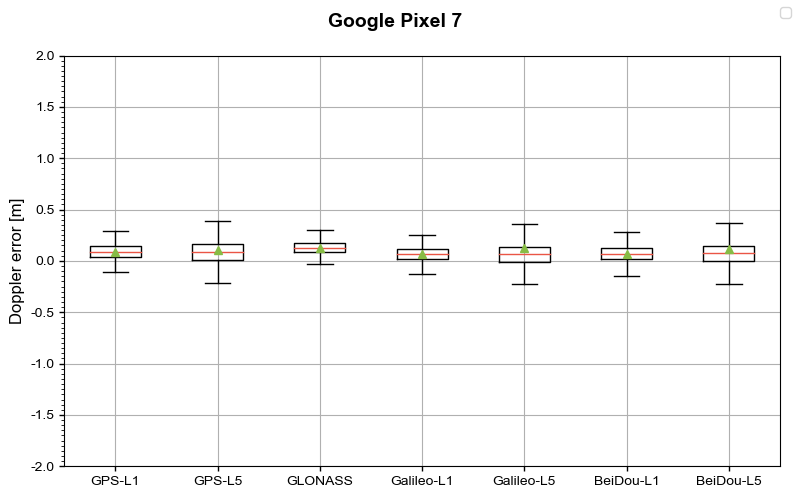

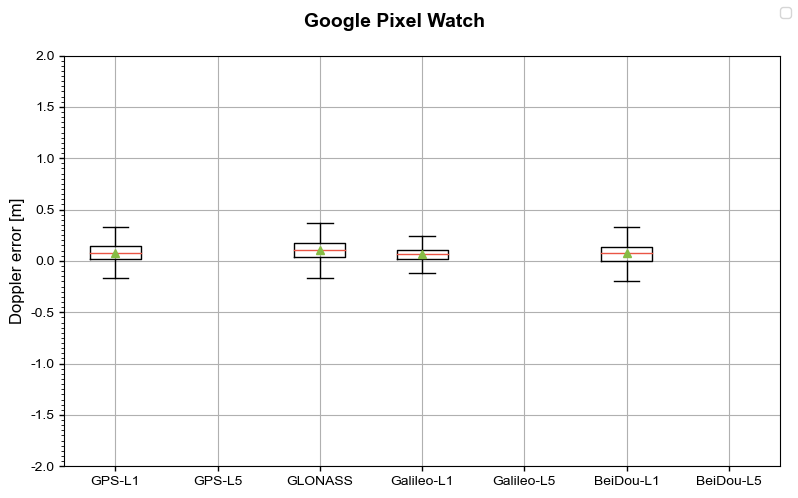

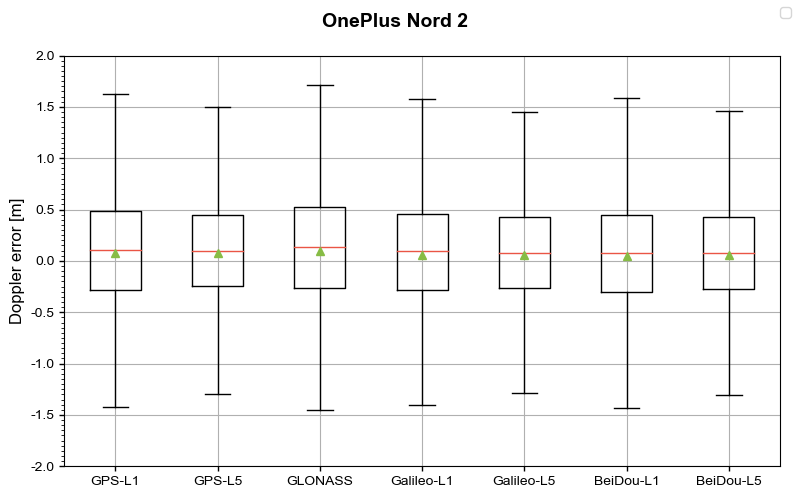

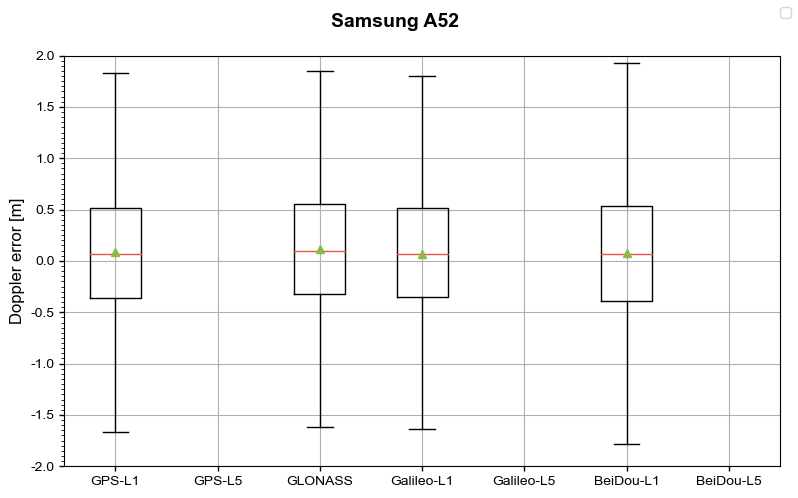

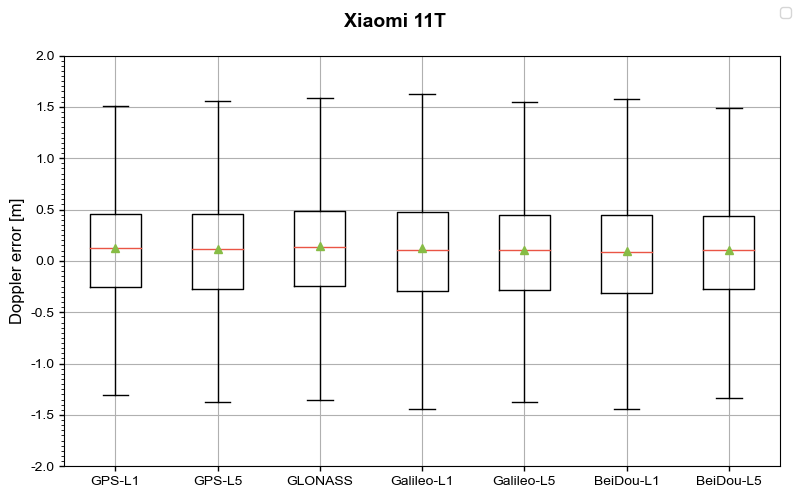

In [13]:
_logs = copy.deepcopy(logs)
for log in _logs:
    log.raw = misc.filterValues(log.raw, 'DopplerError', 300)
plotStatisticsDataBox(_logs, 
                      'DopplerError', 
                      'Doppler error [m]', 
                      ('G', 'R', 'E', 'C'), 
                      ('L1', 'L5'),
                      lim=2,
                      ticks=[0.05,0.5])

Phases

--- Pixel 7 ---
count    62020.000000
mean         0.089458
std          0.575235
min        -20.030491
50%          0.073663
66.7%        0.106081
95%          0.321502
99.7%        2.516578
max         21.324966
Name: PhaseError, dtype: float64
--- Pixel Watch ---
count    33256.000000
mean         0.095071
std          0.232739
min         -1.831877
50%          0.081599
66.7%        0.120482
95%          0.377970
99.7%        1.382904
max          1.835072
Name: PhaseError, dtype: float64
--- Nord 2 ---
count    85454.000000
mean         0.141978
std          4.696983
min       -186.762104
50%          0.087092
66.7%        0.284372
95%          1.189747
99.7%       12.475090
max        184.906967
Name: PhaseError, dtype: float64
--- A52 ---
count    0.0
mean     NaN
std      NaN
min      NaN
50%      NaN
66.7%    NaN
95%      NaN
99.7%    NaN
max      NaN
Name: PhaseError, dtype: float64
--- 11T ---
count    84577.000000
mean         0.140526
std          0.982511
min        -12.5

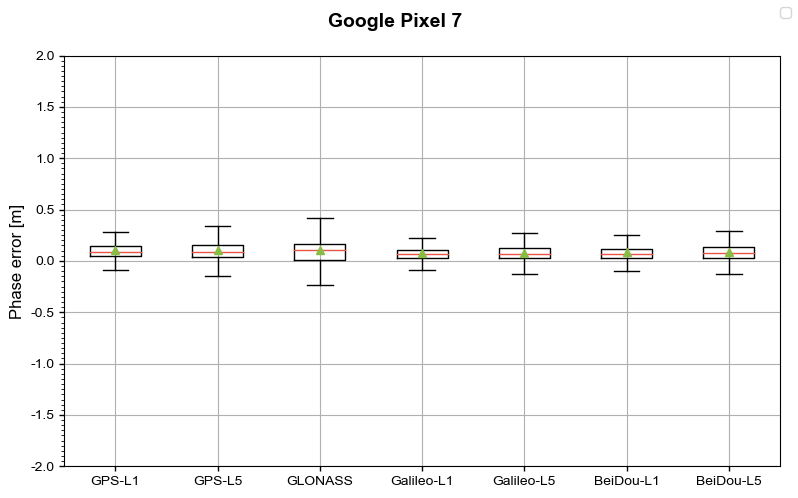

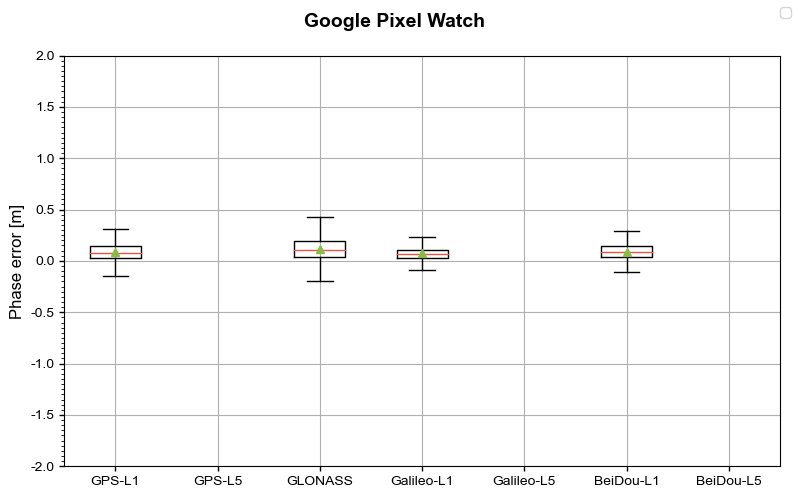

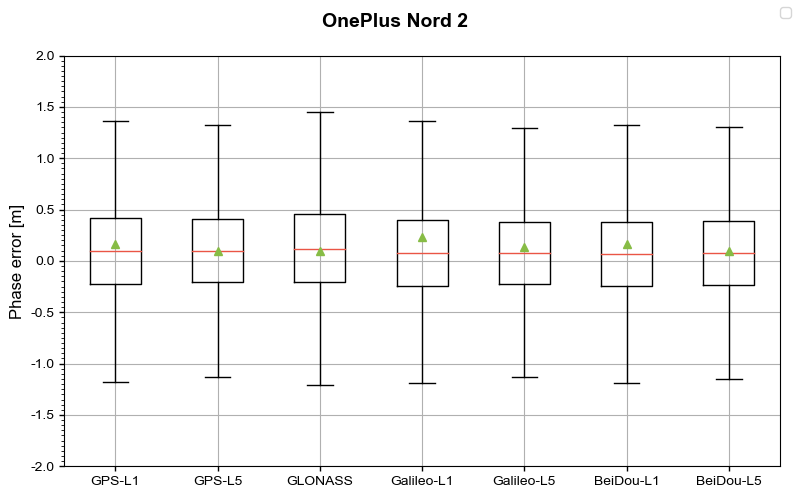

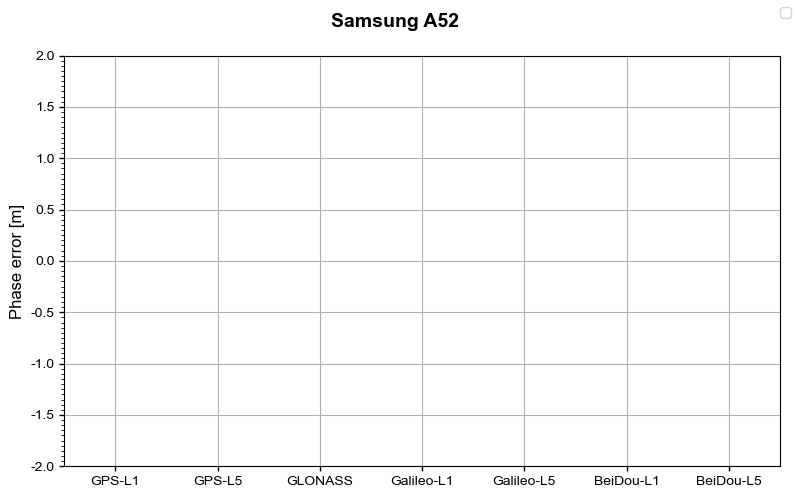

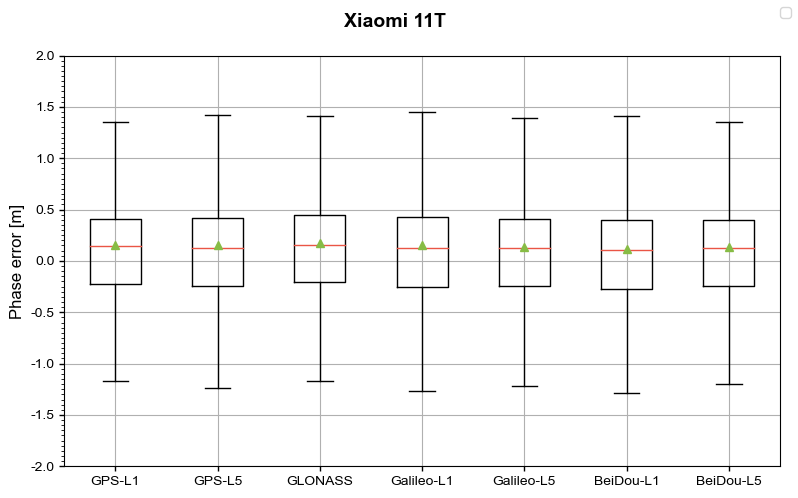

In [14]:
_logs = copy.deepcopy(logs)
for log in _logs:
    print(f"--- {log.device} ---")
    log.raw = misc.filterPercentile(log.raw, 'PhaseError', 0.997)
    print(log.raw['PhaseError'].describe(percentiles=[0.5, .667, .95, .997]).T)
plotStatisticsDataBox(_logs, 
                      'PhaseError', 
                      'Phase error [m]', 
                      ('G', 'R', 'E', 'C'), 
                      ('L1', 'L5'),
                      lim=2,
                      ticks=[0.05,0.5])
    

In [15]:
_logs = copy.deepcopy(logs)
for log in _logs:
    log.raw[list(misc.GnssStateADR_Str.values())] = log.raw.apply(lambda row: misc.getSplitState(row['AccumulatedDeltaRangeState'], bits=5, type='phase'), axis='columns', result_type='expand')


In [16]:
for log in _logs:
    print(f"--- {log.device} ---")
    count = log.raw[list(misc.GnssStateADR_Str.values())].count()
    print(log.raw[list(misc.GnssStateADR_Str.values())].sum().div(count).mul(100))

--- Pixel 7 ---
ADR_UNKNOWN                  0.000000
ADR_VALID                   76.770878
ADR_RESET                    0.000000
ADR_CYCLE_SLIP               0.566681
ADR_HALF_CYCLE_RESOLVED     72.644031
ADR_HALF_CYCLE_REPORTED    100.000000
dtype: float64
--- Pixel Watch ---
ADR_UNKNOWN                  0.000000
ADR_VALID                   78.832487
ADR_RESET                    0.005972
ADR_CYCLE_SLIP               4.643177
ADR_HALF_CYCLE_RESOLVED     67.611227
ADR_HALF_CYCLE_REPORTED    100.000000
dtype: float64
--- Nord 2 ---
ADR_UNKNOWN                  0.000000
ADR_VALID                   82.392986
ADR_RESET                    0.000000
ADR_CYCLE_SLIP               7.858327
ADR_HALF_CYCLE_RESOLVED     77.790019
ADR_HALF_CYCLE_REPORTED    100.000000
dtype: float64
--- A52 ---
ADR_UNKNOWN                  0.0
ADR_VALID                    0.0
ADR_RESET                    0.0
ADR_CYCLE_SLIP               0.0
ADR_HALF_CYCLE_RESOLVED      0.0
ADR_HALF_CYCLE_REPORTED    100.0
dtype: flo